**Importing relevant libraries**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os
from os import listdir
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


['sample_submission.csv', 'train', 'test', 'train.csv']


In [2]:
!pip install tensorflow==2.0.0-beta1

from tensorflow.python.ops import control_flow_util
control_flow_util.ENABLE_CONTROL_FLOW_V2 = True

     |████████████████████████████████| 87.9MB 528kB/s 
     |████████████████████████████████| 3.1MB 33.0MB/s 
     |████████████████████████████████| 501kB 41.5MB/s 
ERROR: ethnicolr 0.2.1 has requirement tensorflow==1.12.3, but you'll have tensorflow 2.0.0b1 which is incompatible.
  Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0


In [3]:
import tensorflow as tf


**Checking the data**

In [4]:
training_dir = '../input/train/train/'
training_imgs = listdir(training_dir)
num_training_imgs = len(training_imgs)
num_training_imgs

17500

 So there are 17500 images in the given data. The labels of these images are saved in 'train.csv' file

In [5]:
train_labels_df = pd.read_csv('../input/train.csv', index_col = 'id')
print("total entries : " + str(train_labels_df.size))
train_labels_df.head()

total entries : 17500


,has_cactus
id,
0004be2cfeaba1c0361d39e2b000257b.jpg,1
000c8a36845c0208e833c79c1bffedd1.jpg,1
000d1e9a533f62e55c289303b072733d.jpg,1
0011485b40695e9138e92d0b3fb55128.jpg,1
0014d7a11e90b62848904c1418fc8cf2.jpg,1


Calculating the pictures with cactus and without cactus

In [6]:
pd.value_counts(train_labels_df['has_cactus'])

1    13136
0     4364
Name: has_cactus, dtype: int64

Nearly 3 times more pictures have cactus in them as compared to the pictures without cactus

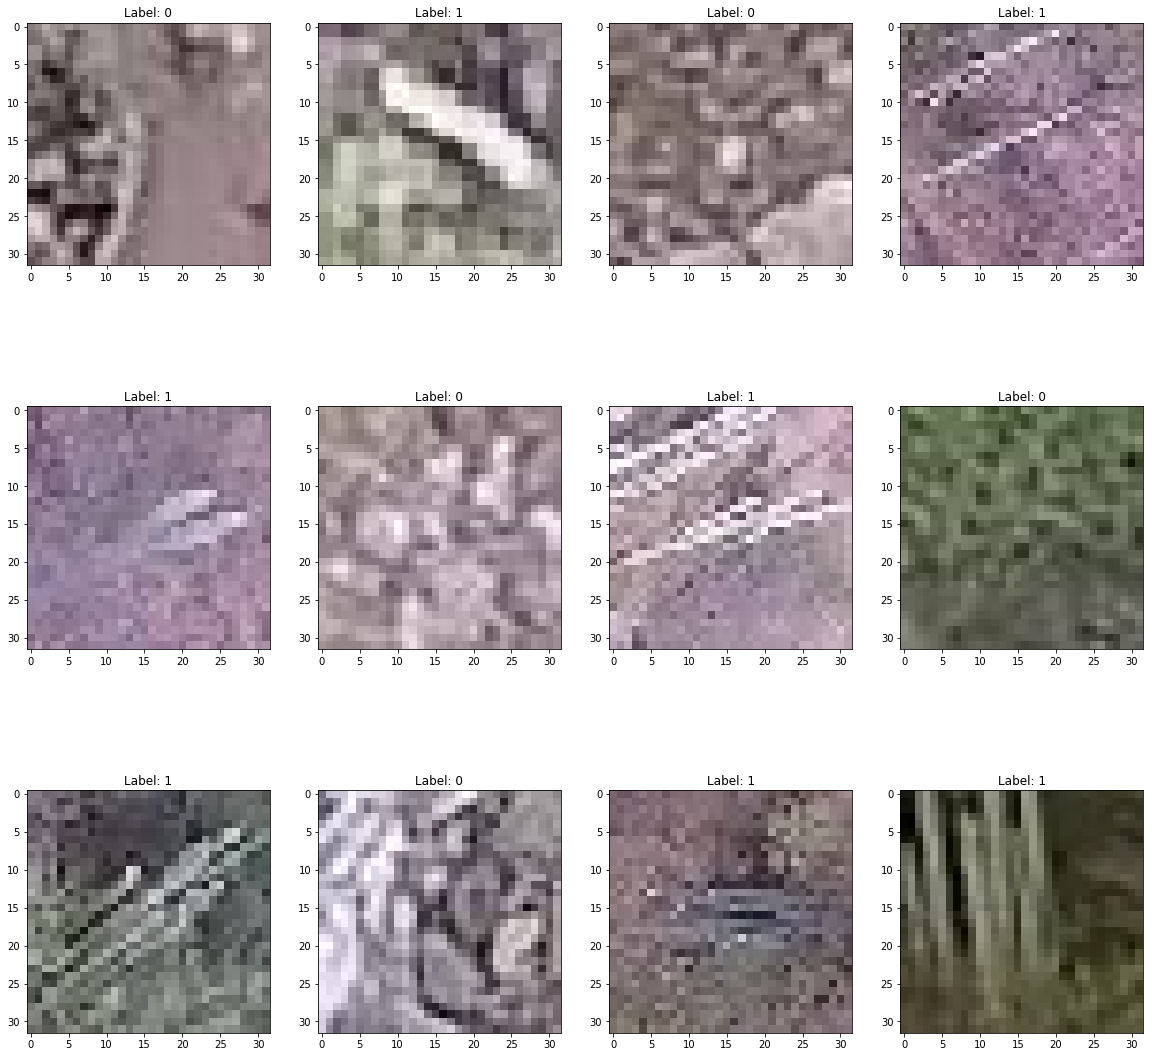

In [7]:
def get_test_image_path(id):
    return training_dir + id

def draw_cactus_image(id, ax):
    path = get_test_image_path(id)
    img = mpimg.imread(path)
    plt.imshow(img)
    ax.set_title('Label: ' + str(train_labels_df.loc[id]['has_cactus']))

fig = plt.figure(figsize=(20,20))
for i in range(12):
    ax = fig.add_subplot(3, 4, i + 1)
    draw_cactus_image(training_imgs[i], ax)

It is really tough to differentiate between the images with cactus and without cactus, so we're going to rely on AI to do that

**Loading the data**

In [8]:
train_image_path = [training_dir + ti for ti in training_imgs ]
train_image_labels = [ train_labels_df.loc[ti]['has_cactus'] for ti in training_imgs]


for i in range(10):
    print(train_image_path[i], train_image_labels[i])

../input/train/train/76719301e2033d74e083c596ae270479.jpg 0
../input/train/train/add01a62be65e0d8910190a2802da395.jpg 1
../input/train/train/9c554015a12095b76b92ee24a9221bc5.jpg 0
../input/train/train/02b6bbd919ce487e614a541e8c781e47.jpg 1
../input/train/train/72ad70e21bc47bfdc10d6a86aa99e058.jpg 1
../input/train/train/16efd28136238b6b6177567fd1909f72.jpg 0
../input/train/train/94d124ceb307d98e3df139783c5fc908.jpg 1
../input/train/train/c2152191fa3654034873f2c0a6fe9593.jpg 0
../input/train/train/dca1b6d310815beedfe102d36c43fc46.jpg 1
../input/train/train/f964be8da498ec4e98155a331367f689.jpg 0


To get from the image paths above to actual tf.Tensors we will combine tf.io.read_file and tf.image.decode_image. This very simple process is illustrated below for the first example:

In [9]:
def img_to_tensor(img_path):
    img_tensor = tf.cast(tf.image.decode_image(tf.io.read_file(img_path)), tf.float32)
    img_tensor /= 255.0 # normalized to [0,1]
    return img_tensor

img_to_tensor(train_image_path[0])

<tf.Tensor: id=19, shape=(32, 32, 3), dtype=float32, numpy=
array([[[0.5254902 , 0.4862745 , 0.48235294],
        [0.57254905, 0.53333336, 0.5294118 ],
        [0.7176471 , 0.6784314 , 0.6745098 ],
        ...,
        [0.6745098 , 0.61960787, 0.61960787],
        [0.60784316, 0.5529412 , 0.5529412 ],
        [0.61960787, 0.5647059 , 0.5647059 ]],

       [[0.46666667, 0.42745098, 0.42352942],
        [0.5058824 , 0.46666667, 0.4627451 ],
        [0.6392157 , 0.6       , 0.59607846],
        ...,
        [0.69803923, 0.6431373 , 0.6431373 ],
        [0.6156863 , 0.56078434, 0.56078434],
        [0.62352943, 0.5686275 , 0.5686275 ]],

       [[0.45490196, 0.41568628, 0.4117647 ],
        [0.47843137, 0.4392157 , 0.43529412],
        [0.5372549 , 0.49803922, 0.49411765],
        ...,
        [0.75686276, 0.7019608 , 0.7019608 ],
        [0.6156863 , 0.56078434, 0.56078434],
        [0.6039216 , 0.54901963, 0.54901963]],

       ...,

       [[0.5176471 , 0.4627451 , 0.4627451 ],
        

So this is how we can convert our example to tensor of shape (32,32,3)

**Making training and validation dataset from our data**

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(train_image_path, train_image_labels, test_size=0.2)

def process_image_in_record(path, label):
    return img_to_tensor(path), label

def build_training_dataset(paths, labels, batch_size = 32):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(process_image_in_record)
    ds = ds.shuffle(buffer_size = len(paths))
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

def build_validation_dataset(paths, labels, batch_size = 32):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(process_image_in_record)
    ds = ds.batch(batch_size)
    return ds

train_ds = build_training_dataset(X_train, y_train)
validation_ds = build_validation_dataset(X_valid, y_valid)

Now that we have created training and validation dataset, let's verify them by a small example

In [12]:
mini_train_ds = build_training_dataset(X_train[:5], y_train[:5], batch_size=2)
# Fetch and print the first batch of 2 images
for images, labels in mini_train_ds.take(1):
    print(images)
    print(labels)

tf.Tensor(
[[[[0.47843137 0.41568628 0.3647059 ]
   [0.43137255 0.36862746 0.31764707]
   [0.38039216 0.30980393 0.27058825]
   ...
   [0.4862745  0.4        0.34901962]
   [0.45490196 0.36862746 0.31764707]
   [0.5372549  0.4509804  0.4       ]]

  [[0.43137255 0.36862746 0.31764707]
   [0.43529412 0.37254903 0.32156864]
   [0.36862746 0.29803923 0.2509804 ]
   ...
   [0.5411765  0.45490196 0.40392157]
   [0.5137255  0.42745098 0.3764706 ]
   [0.5568628  0.47058824 0.41960785]]

  [[0.5882353  0.5254902  0.46666667]
   [0.49803922 0.43529412 0.3764706 ]
   [0.3137255  0.2509804  0.19215687]
   ...
   [0.54509807 0.47058824 0.41568628]
   [0.54509807 0.45882353 0.40784314]
   [0.54509807 0.45882353 0.40784314]]

  ...

  [[0.44313726 0.38431373 0.35686275]
   [0.5176471  0.45882353 0.43137255]
   [0.45490196 0.39607844 0.36862746]
   ...
   [0.4627451  0.41568628 0.3529412 ]
   [0.36078432 0.3254902  0.25882354]
   [0.43529412 0.4        0.33333334]]

  [[0.34509805 0.29411766 0.258823

**Building a model**

In [13]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # because we are in a binary classification setup

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
history = model.fit(train_ds, epochs=20, steps_per_epoch=400, validation_data=validation_ds)

Epoch 1/20
400/400 [==============================] - 28s 70ms/step - loss: 0.4729 - accuracy: 0.7646 - val_loss: 0.4840 - val_accuracy: 0.7709
Epoch 2/20
400/400 [==============================] - 10s 25ms/step - loss: 0.3752 - accuracy: 0.8168 - val_loss: 0.3748 - val_accuracy: 0.8051
Epoch 3/20
400/400 [==============================] - 10s 25ms/step - loss: 0.3544 - accuracy: 0.8325 - val_loss: 0.3745 - val_accuracy: 0.8306
Epoch 4/20
400/400 [==============================] - 10s 25ms/step - loss: 0.3421 - accuracy: 0.8359 - val_loss: 0.3064 - val_accuracy: 0.8703
Epoch 5/20
400/400 [==============================] - 10s 26ms/step - loss: 0.3231 - accuracy: 0.8587 - val_loss: 0.3310 - val_accuracy: 0.8603
Epoch 6/20
400/400 [==============================] - 10s 25ms/step - loss: 0.2928 - accuracy: 0.8770 - val_loss: 0.2999 - val_accuracy: 0.8806
Epoch 7/20
400/400 [==============================] - 9s 23ms/step - loss: 0.3067 - accuracy: 0.8672 - val_loss: 0.3204 - val_accuracy: 

We've reached 90% validation accurary and there was increase in the validation loss once.

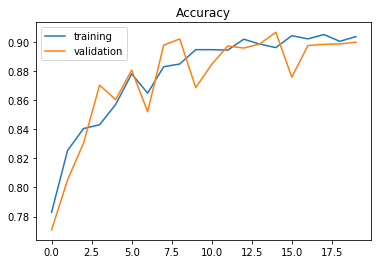

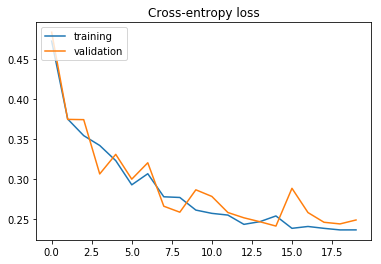

In [15]:
def plot_accuracies_and_losses(history):
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    
    plt.title('Cross-entropy loss')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()

plot_accuracies_and_losses(history)

This shows us that our model is learning something and getting better gradually, we didn't allow much overfitting to occur. This shows that we haven't made any errors in setting up our data pipeline and model

Furthermore, we were using basic model till now, but CNN or convulated neural networks are the most preferred option when processing image data, so let's try using CNNs

**Making a CNN model**

In [16]:
cnn_model = tf.keras.Sequential()

cnn_model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)))
cnn_model.add(tf.keras.layers.MaxPooling2D((2,2)))
cnn_model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling2D((2,2)))
cnn_model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))

cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dense(64, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)               

In [18]:
history = cnn_model.fit(train_ds, epochs=20, steps_per_epoch=400, validation_data=validation_ds)

Epoch 1/20
400/400 [==============================] - 27s 67ms/step - loss: 0.2315 - accuracy: 0.9060 - val_loss: 0.1222 - val_accuracy: 0.9537
Epoch 2/20
400/400 [==============================] - 23s 57ms/step - loss: 0.1373 - accuracy: 0.9482 - val_loss: 0.0884 - val_accuracy: 0.9686
Epoch 3/20
400/400 [==============================] - 25s 62ms/step - loss: 0.0990 - accuracy: 0.9640 - val_loss: 0.0789 - val_accuracy: 0.9720
Epoch 4/20
400/400 [==============================] - 24s 60ms/step - loss: 0.0935 - accuracy: 0.9644 - val_loss: 0.0809 - val_accuracy: 0.9726
Epoch 5/20
400/400 [==============================] - 22s 55ms/step - loss: 0.0712 - accuracy: 0.9741 - val_loss: 0.0584 - val_accuracy: 0.9806
Epoch 6/20
400/400 [==============================] - 20s 50ms/step - loss: 0.0743 - accuracy: 0.9726 - val_loss: 0.0767 - val_accuracy: 0.9726
Epoch 7/20
400/400 [==============================] - 21s 53ms/step - loss: 0.0619 - accuracy: 0.9769 - val_loss: 0.0413 - val_accuracy:

**Making a Submission**

In [19]:
test_dir = '../input/test/test/'
test_imgs = listdir(test_dir)
print(len(test_imgs))
test_imgs[:5]

4000


['dadfb5ca7c1ded00aac585bdbea2c66c.jpg',
 '7f8ee9354b1a12c01832ee4115d703e8.jpg',
 '546cb4e0e46927319d60c5b6d64521a2.jpg',
 'ad7540778cc3cfdcc1ee326ae4659af8.jpg',
 'fd4f6c93466b6c3438e1d7b616328b00.jpg']

In [20]:
def path_to_numpy_array(path):
    tensor = img_to_tensor(path)
    array = tensor.numpy()
    return array

test_image_paths = [test_dir + ti for ti in test_imgs]
test_instances = np.asarray([path_to_numpy_array(tip) for tip in test_image_paths])

test_instances[:2]

array([[[[0.27058825, 0.23137255, 0.23529412],
         [0.30588236, 0.26666668, 0.27058825],
         [0.32941177, 0.2901961 , 0.29411766],
         ...,
         [0.3647059 , 0.31764707, 0.31764707],
         [0.35686275, 0.30980393, 0.30980393],
         [0.34117648, 0.29411766, 0.29411766]],

        [[0.2784314 , 0.23921569, 0.24313726],
         [0.28235295, 0.24313726, 0.24705882],
         [0.28235295, 0.24313726, 0.24705882],
         ...,
         [0.3882353 , 0.34117648, 0.34117648],
         [0.3764706 , 0.32941177, 0.32941177],
         [0.33333334, 0.28627452, 0.28627452]],

        [[0.29803923, 0.25882354, 0.2627451 ],
         [0.28235295, 0.24313726, 0.24705882],
         [0.27058825, 0.23137255, 0.23529412],
         ...,
         [0.3137255 , 0.26666668, 0.26666668],
         [0.3372549 , 0.2901961 , 0.2901961 ],
         [0.3137255 , 0.26666668, 0.26666668]],

        ...,

        [[0.33333334, 0.2784314 , 0.32941177],
         [0.31764707, 0.2627451 , 0.3137255 ]

In [21]:
predictions = cnn_model.predict(test_instances)
print(len(predictions))

4000


In [22]:
submission_data = pd.DataFrame({'id': test_imgs, 'has_cactus': predictions.flatten()})
submission_data.head(20)

,id,has_cactus
0,dadfb5ca7c1ded00aac585bdbea2c66c.jpg,0.999999
1,7f8ee9354b1a12c01832ee4115d703e8.jpg,0.000692
2,546cb4e0e46927319d60c5b6d64521a2.jpg,0.000049
3,ad7540778cc3cfdcc1ee326ae4659af8.jpg,1.000000
4,fd4f6c93466b6c3438e1d7b616328b00.jpg,1.000000
5,03854bb8a431afcc9995d639d7761055.jpg,0.570617
6,ab4b86f50eb4d2b936719b5f31fd1ed4.jpg,0.001399
7,3d497d059c2c5a5680c7aab6dbe9d8c8.jpg,1.000000
8,119f2dd44df56fa4d8032199f4231353.jpg,0.901451
9,588be7b33f883603211bdb77f394c4ed.jpg,1.000000


In [23]:
submission_data.to_csv('submission.csv', index=False)

In [24]:
!head submission.csv

id,has_cactus
dadfb5ca7c1ded00aac585bdbea2c66c.jpg,0.9999987
7f8ee9354b1a12c01832ee4115d703e8.jpg,0.00069224834
546cb4e0e46927319d60c5b6d64521a2.jpg,4.8816204e-05
ad7540778cc3cfdcc1ee326ae4659af8.jpg,1.0
fd4f6c93466b6c3438e1d7b616328b00.jpg,1.0
03854bb8a431afcc9995d639d7761055.jpg,0.57061726
ab4b86f50eb4d2b936719b5f31fd1ed4.jpg,0.0013988316
3d497d059c2c5a5680c7aab6dbe9d8c8.jpg,1.0
119f2dd44df56fa4d8032199f4231353.jpg,0.9014509
